# Events analysis

In [1]:
import sys
import os
parent_folder_path = os.path.abspath(os.path.join(os.getcwd(), "..", "utils"))
sys.path.append(parent_folder_path)
from utils import arrify_string_columns, deep_copy
data_folder = os.path.join("..", "data")

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.ticker import MaxNLocator 
import seaborn as sns
from collections import Counter

In [2]:
original_df = pd.read_csv(os.path.join(data_folder, "time_sorted_table.csv"), sep=';', index_col=0)
arrify_string_columns(original_df)

## General analysis

In [3]:
df = deep_copy(original_df)

df['num_events'] = df['events_sequence'].apply(lambda x: len(x))
df['num_vehicles'] = df['vehicles_sequence'].apply(lambda x: len(set(x)))

In [4]:
print(df.num_events.describe())
print()
print(df.num_vehicles.describe())
print()

count    1011.000000
mean      553.197824
std       314.852092
min        10.000000
25%       307.500000
50%       554.000000
75%       746.000000
max      2407.000000
Name: num_events, dtype: float64

count    1011.000000
mean        1.748764
std         0.724525
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: num_vehicles, dtype: float64



In [5]:

def get_stats_incidents(dataframe):
    stats_incidents = dataframe.groupby('incident_type').size().reset_index(name='count')
    stats_incidents['percentage'] = (stats_incidents['count'] / len(dataframe)) * 100
    original_stats = original_df.groupby('incident_type').size().reset_index(name='count_original')
    stats_incidents = stats_incidents.merge(original_stats, how='inner', on='incident_type')
    stats_incidents['count_percentage_on_total'] = stats_incidents['count']/stats_incidents['count_original'] * 100
    stats_incidents = stats_incidents.drop('count_original', axis=1)
    
    return stats_incidents


get_stats_incidents(original_df)

,incident_type,count,percentage,count_percentage_on_total
0,2,119,11.770524,100.0
1,3,5,0.494560,100.0
2,4,78,7.715134,100.0
3,6,6,0.593472,100.0
4,7,4,0.395648,100.0
5,9,117,11.572700,100.0
6,11,26,2.571711,100.0
7,13,318,31.454006,100.0
8,14,149,14.737883,100.0
9,16,4,0.395648,100.0


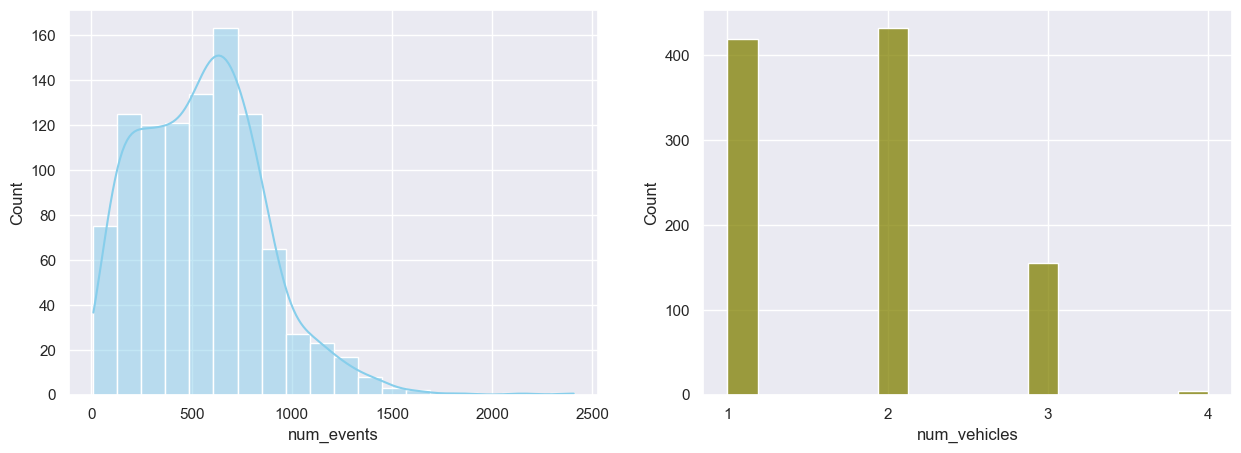

In [6]:
sns.set_theme(style="darkgrid")
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df, x="num_events", bins=20, color='skyblue', ax=axs[0], kde=True)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
sns.histplot(data=df, x="num_vehicles", color='olive', ax=axs[1])

plt.show()

## Electricity Analysis

In [7]:
df[['both_true', 'both_false']] = df.apply(
    lambda row: pd.Series({
        'both_true': [r1 and r2 for r1, r2 in zip(row.dj_ac_state_sequence, row.dj_dc_state_sequence)],
        'both_false': [not r1 and not r2 for r1, r2 in zip(row.dj_ac_state_sequence, row.dj_dc_state_sequence)]
    }), 
    axis=1
)

We can see that at any time no train is connected to both AC and DC

In [8]:
df[df['both_true'].apply(lambda x: any(x))].size

0

In [9]:
always_on_battery = deep_copy(df[df['both_false'].apply(lambda x: all(x))])

In [10]:
df.loc[always_on_battery.index]

,incident_id,vehicles_sequence,events_sequence,seconds_to_incident_sequence,approx_lat,approx_lon,train_kph_sequence,dj_ac_state_sequence,dj_dc_state_sequence,incident_type,num_events,num_vehicles,both_true,both_false
155,4440081,"[1090, 1090, 1090, 1090, 1090, 1090, 1090, 109...","[2492, 3986, 4002, 1032, 1082, 1132, 2852, 411...","[-14344, -14291, -13960, -13960, -13960, -1396...",50.956162,5.091324,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",14,218,1,"[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru..."
486,4455925,"[704, 704, 704, 704, 704, 704, 704, 704, 704, ...","[4002, 2852, 4110, 2854, 4092, 4094, 4026, 270...","[-1820, -1818, -1818, -1816, -1815, -1815, -18...",50.894239,4.409328,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",14,78,1,"[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru..."
621,4461601,"[1047, 1047, 1047, 1047, 1047, 1047, 1047, 104...","[4396, 2288, 2462, 4394, 2464, 2288, 2742, 402...","[-12007, -11610, -11610, -11610, -11609, -1158...",49.678457,5.816943,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",99,344,1,"[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru..."
759,4468195,"[1027, 1027, 1027, 1027, 1027, 1027, 1027, 102...","[4004, 2852, 4110, 2854, 4092, 4094, 4026, 249...","[-13237, -13235, -13235, -13233, -13232, -1323...",50.618932,5.573920,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",14,78,1,"[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru..."
825,4601001,"[1009, 1009, 1009, 1009, 1009, 1009, 1009, 100...","[4002, 4032, 4028, 4026, 4110, 2852, 2854, 410...","[-7561, -7561, -7560, -7559, -7559, -7558, -75...",50.189588,5.953584,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",6,45,1,"[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru..."
917,4606573,"[650, 650, 650, 650, 650, 650, 650, 650, 650, ...","[4002, 4092, 4094, 2852, 4110, 2854, 4026, 398...","[-2445, -2444, -2444, -2442, -2442, -2440, -24...",51.012874,3.779166,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",99,119,1,"[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru..."


In [11]:
always_on_battery.seconds_to_incident_sequence.map(lambda x: x[::-1])

155    [-3760, -3825, -3837, -3842, -3868, -3875, -38...
486    [-26, -230, -230, -297, -305, -305, -321, -377...
621    [3122, 1568, 1547, 1546, 1342, 1342, 1312, 130...
759    [591, 401, 401, 398, 331, 330, 330, 314, 313, ...
825    [-6305, -6305, -6354, -6372, -6423, -6428, -64...
917    [1637, 1633, 1633, 1633, 1633, 1632, 1632, 163...
Name: seconds_to_incident_sequence, dtype: object

## Events that stops logging before instant 0

In [12]:
def get_records_that_stopped_before_epsilon(dataframe, epsilon):
    return dataframe[dataframe.apply(lambda x: x.seconds_to_incident_sequence[-1] < epsilon, axis=1)]

Number of rows that stopped logging from 1 seconds before the zero: 18
Number of rows that stopped logging from 2 seconds before the zero: 18
Number of rows that stopped logging from 4 seconds before the zero: 18
Number of rows that stopped logging from 9 seconds before the zero: 18
Number of rows that stopped logging from 19 seconds before the zero: 17
Number of rows that stopped logging from 40 seconds before the zero: 16
Number of rows that stopped logging from 86 seconds before the zero: 15
Number of rows that stopped logging from 181 seconds before the zero: 12
Number of rows that stopped logging from 380 seconds before the zero: 11
Number of rows that stopped logging from 799 seconds before the zero: 9
Number of rows that stopped logging from 1680 seconds before the zero: 6
Number of rows that stopped logging from 3530 seconds before the zero: 4
Number of rows that stopped logging from 7419 seconds before the zero: 1
Number of rows that stopped logging from 13329 seconds before t

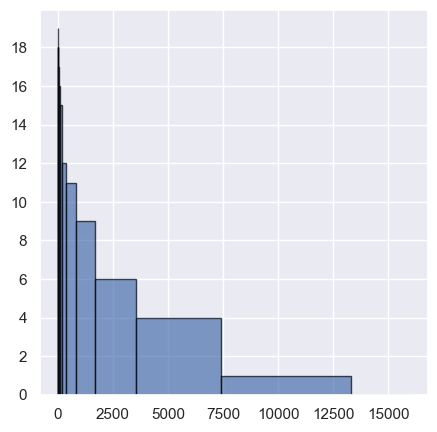

In [13]:
records_stop_log_before_0 = get_records_that_stopped_before_epsilon(df, 0)
last_second_logged = records_stop_log_before_0['seconds_to_incident_sequence'].apply(lambda x: -x[-1])

bins = np.logspace(0, 15, num=15, base=2, dtype='int')
bins[-2] = max(last_second_logged) + 1
bins[-1] = 16000

for epsilon in bins: 
    print(f"Number of rows that stopped logging from {epsilon} seconds before the zero: {len(get_records_that_stopped_before_epsilon(df, -epsilon))}")

fig, ax = plt.subplots(figsize=(5, 5))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.hist(last_second_logged, bins=bins, edgecolor='black', alpha=0.7, cumulative=-1)
plt.show()

What shall we do with these records? 

We can see that they say nothing about the type of incident

In [14]:
get_stats_incidents(get_records_that_stopped_before_epsilon(df, -600))

,incident_type,count,percentage,count_percentage_on_total
0,4,1,10.0,1.282051
1,6,1,10.0,16.666667
2,13,1,10.0,0.314465
3,14,3,30.0,2.013423
4,99,4,40.0,2.285714


## Speed analysis

Delta lists of an attribute is the list that has for elements the difference between one element and its preceding one in the attribute list 

The element 0 is the initial value

In [15]:
def kph_to_ms(speed):
    return speed/3.6


def calculate_deltas(row):
    deltas = list.copy(row)
    for idx in range(len(row)):
        if idx != 0:
            deltas[idx] = row[idx] - row[idx - 1]
    return deltas


df['speed'] = df.train_kph_sequence.apply(lambda speeds: [kph_to_ms(speed) for speed in speeds])
df['speed_delta'] = df.speed.apply(lambda speed: calculate_deltas(speed))
df['time_delta'] = df.seconds_to_incident_sequence.apply(lambda time: calculate_deltas(time))

We calculate the acceleration as $\frac{\Delta v}{\Delta t}$.

If $\Delta t = 0$ and $\Delta v \neq 0$ it means that there was a variation of speed in less than a second, we will specify with $\epsilon$ the possible speed variation allowed after which we consider what we are seeing as an error and assign it an immensely high value for the acceleration, marking it as a possible error

In [16]:
MAX_ACCELERATION = 9_999_999_999_999

def calculate_acceleration(delta_speed, delta_time):
    epsilon = 5 
    acceleration = 0.0
    if delta_time != 0:
        acceleration = delta_speed / delta_time
    if delta_time == 0 and abs(delta_speed) > epsilon:
        acceleration = MAX_ACCELERATION 
    return acceleration
        

df['acceleration'] = df.apply(
    lambda row: [calculate_acceleration(speed, time) for speed, time in zip(row.speed_delta, row.time_delta)], 
    axis=1
)

df.acceleration = df.acceleration.apply(lambda row: row[1:])

We remove the first element of the acceleration, first because it has no meaning given that it is given by the division of the initial speed and time but also because in this way we are giving the acceleration meaning to the first value of each couple.

So given elements $i$ and $i+1$, this will be satisfied: $v_{i+1} = v_{i} + a_i  \Delta t_{i+1}$

In [17]:
def get_indexes_max_acceleration(acceleration_list):
    accelerations = np.array(acceleration_list)
    return np.where(accelerations >= MAX_ACCELERATION)[0]


speed_error_different_vehicles = []
speed_error_same_vehicles = []

for row_index, row in enumerate(df.acceleration.apply(get_indexes_max_acceleration)):
    if row.size > 0:
        for list_index in row:
            tuple = df.loc[row_index]
            if tuple.vehicles_sequence[list_index] == tuple.vehicles_sequence[list_index+1]:
                speed_error_same_vehicles.append((row_index, list_index, tuple.vehicles_sequence[list_index], round(tuple.speed_delta[list_index+1], 4)))
            else: 
                speed_error_different_vehicles.append((row_index, list_index, tuple.vehicles_sequence[list_index:list_index+2], round(tuple.speed_delta[list_index+1], 4)))


print(f"Number of speed errors but because of vehicle switch: {len(speed_error_different_vehicles)}")
print(f"Number of speed errors on the same vehicle: {len(speed_error_same_vehicles)}")
speed_error_same_vehicles

Number of speed errors but because of vehicle switch: 831
Number of speed errors on the same vehicle: 19


[(381, 768, 1001, -10.0278),
 (913, 679, 658, -16.0278),
 (913, 680, 658, 15.9444),
 (913, 682, 658, -15.9722),
 (913, 729, 658, -14.3333),
 (913, 730, 658, 14.3333),
 (913, 741, 658, -7.3611),
 (913, 744, 658, 7.3611),
 (913, 766, 658, -7.4444),
 (913, 780, 658, -7.5556),
 (913, 799, 658, -8.0833),
 (913, 801, 658, 7.9722),
 (913, 802, 658, -7.9722),
 (913, 811, 658, -10.3056),
 (913, 813, 658, 10.1389),
 (913, 814, 658, -10.1389),
 (913, 831, 658, 11.1944),
 (913, 832, 658, -11.1944),
 (913, 833, 658, 11.1667)]

In [18]:
def has_specific_acceleration_values(accelerations, comparing_function):
    for acceleration_value in accelerations:
        if comparing_function(acceleration_value):
            return True
    
    return False


def has_speed_over_threshold(accelerations, threshold):
    return has_specific_acceleration_values(accelerations, lambda acc: acc >= threshold and acc < MAX_ACCELERATION)

def has_speed_error(accelerations, threshold):
    return has_specific_acceleration_values(accelerations, lambda acc: acc >= threshold)

In [19]:
df_with_high_speed = df[df['acceleration'].apply(lambda x: has_speed_over_threshold(x, 10))]
df_with_speed_error = df[df['acceleration'].apply(lambda x: has_speed_error(x, MAX_ACCELERATION))]
print(get_stats_incidents(df_with_high_speed))
print(get_stats_incidents(df_with_speed_error))

    incident_type  count  percentage  count_percentage_on_total
0               2     60   40.816327                  50.420168
1               3      1    0.680272                  20.000000
2               4     20   13.605442                  25.641026
3               6      1    0.680272                  16.666667
4               7      1    0.680272                  25.000000
5               9     14    9.523810                  11.965812
6              11      6    4.081633                  23.076923
7              13     20   13.605442                   6.289308
8              14     11    7.482993                   7.382550
9              17      3    2.040816                  30.000000
10             99     10    6.802721                   5.714286
    incident_type  count  percentage  count_percentage_on_total
0               2     60   42.857143                  50.420168
1               3      1    0.714286                  20.000000
2               4     21   15.000000    

There seems to be a relation between trains that reach at a certain point high speed and trains that have speed errors!

In [20]:
def has_emergency_braking(accelerations, threshold):
    for acceleration_value in accelerations:
        if acceleration_value < threshold:
            return True 
    return False


def emergency_braking_id(accelerations, threshold):
    positions = []
    for i, acceleration_value in enumerate(accelerations):
        if acceleration_value < threshold:
            positions.append(i) 

    return positions

g = -9.8
ths = g*0.1
events_correlated_with_emergency_braking = []

for idx, row in enumerate(df.acceleration.apply(lambda x: emergency_braking_id(x, ths))):
    if row == []:
        continue
    else:
        for list_index in row:
            tuple = df.loc[idx]
            if tuple.vehicles_sequence[list_index] == tuple.vehicles_sequence[list_index+1] and tuple.train_kph_sequence[list_index+1] < 5:
                #print(idx, id, tuple.events_sequence[id:id+2], tuple.vehicles_sequence[id:id+2], tuple.time_delta[id+1], tuple.train_kph_sequence[id:id+2], tuple.speed_delta[id+1])
                events_correlated_with_emergency_braking.extend(tuple.events_sequence[list_index:list_index+2])

            


In [21]:
all_events = []
for i in df.events_sequence:
    all_events.extend(i)

event_counts = Counter(all_events)
event_sorted_counts = dict(sorted(event_counts.items(), key=lambda item: item[1], reverse=True))

In [22]:
counts = Counter(events_correlated_with_emergency_braking)
frequency_counts = {}
for i, k in counts.items():
    frequency_counts[i] = (k / event_sorted_counts[i], event_sorted_counts[i])
sorted_counts = dict(sorted(frequency_counts.items(), key=lambda item: item[1][0], reverse=True))
sorted_counts

{920: (0.25, 4),
 146: (0.16666666666666666, 6),
 922: (0.16666666666666666, 6),
 946: (0.15789473684210525, 57),
 962: (0.13333333333333333, 60),
 882: (0.125, 8),
 4080: (0.08742331288343558, 652),
 134: (0.034482758620689655, 29),
 2686: (0.0278503046127067, 1149),
 3238: (0.02564102564102564, 78),
 862: (0.02564102564102564, 39),
 4180: (0.022310756972111555, 1255),
 960: (0.0196078431372549, 102),
 3240: (0.019417475728155338, 103),
 2658: (0.008555133079847909, 1052),
 3236: (0.008264462809917356, 605),
 4070: (0.006666666666666667, 300),
 4128: (0.0064516129032258064, 155),
 380: (0.005952380952380952, 168),
 4066: (0.0055608654096793815, 23018),
 4068: (0.004574964053853862, 22951),
 3254: (0.004408060453400504, 3176),
 2688: (0.0027803521779425394, 1079),
 984: (0.002398081534772182, 417),
 3980: (0.0021645021645021645, 462),
 4394: (0.0020905923344947735, 2870),
 2940: (0.001722158438576349, 1742),
 2684: (0.001589825119236884, 629),
 3234: (0.0015873015873015873, 630),
 4002